In [1]:
import torch
import datasets
import transformers

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import Dict
from torch.utils.data import Dataset
from captum.attr import visualization as viz

from captum.attr import (IntegratedGradients, LayerIntegratedGradients,
                         configure_interpretable_embedding_layer,
                         remove_interpretable_embedding_layer)
from transformers import (ElectraForSequenceClassification,
                          ElectraTokenizerFast, EvalPrediction, InputFeatures,
                          Trainer, TrainingArguments, glue_compute_metrics)

In [2]:
# Model and Tokenizer

model = ElectraForSequenceClassification.from_pretrained(
    "google/electra-small-discriminator", num_labels = 2)

tokenizer = ElectraTokenizerFast.from_pretrained(
    "google/electra-small-discriminator", do_lower_case=True)

Some weights of the model checkpoint at google/electra-small-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier

In [3]:
# Load the SST2 dataset from the datasets library
dataset = datasets.load_dataset("glue", "sst2")

# Look at the labels
print("Training set labels: {}".format(set(dataset["train"]["label"])))
print("Validation set labels: {}".format(set(dataset["validation"]["label"])))
print("Test set labels: {}".format(set(dataset["test"]["label"])))

# Explore the dataset
df = pd.DataFrame({"senence": dataset["train"]["sentence"],
                   "label": dataset["train"]["label"]})
pd.options.display.max_colwidth = 0
df.head()

Reusing dataset glue (/home/mirac13/.cache/huggingface/datasets/glue/sst2/1.0.0/7c99657241149a24692c402a5c3f34d4c9f1df5ac2e4c3759fadea38f6cb29c4)


Training set labels: {0, 1}
Validation set labels: {0, 1}
Test set labels: {-1}


,senence,label
0,hide new secretions from the parental units,0
1,"contains no wit , only labored gags",0
2,that loves its characters and communicates something rather beautiful about human nature,1
3,remains utterly satisfied to remain the same throughout,0
4,on the worst revenge-of-the-nerds clichés the filmmakers could dredge up,0


In [4]:
# Create Dataset class

class TrainerDataset(Dataset):
    def __init__(self, inputs, targets, tokenizer):
        self.inputs = inputs
        self.targets = targets
        self.tokenizer = tokenizer

        self.tokenized_inputs = tokenizer(inputs, padding=True)   

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return InputFeatures(
            input_ids=self.tokenized_inputs['input_ids'][idx],
            token_type_ids=self.tokenized_inputs['token_type_ids'][idx],
            attention_mask=self.tokenized_inputs['attention_mask'][idx],
            label=self.targets[idx])

In [5]:
train_dataset = TrainerDataset(dataset["train"]["sentence"],
                               dataset["train"]["label"], tokenizer)
eval_dataset = TrainerDataset(dataset["validation"]["sentence"],
                              dataset["validation"]["label"], tokenizer)

### Fine Tune

In [6]:
np.random.seed(42)
torch.manual_seed(42)

training_args = TrainingArguments(
    output_dir="electra_sst2",
    num_train_epochs=3,  # (1 epoch gives slightly lower accuracy)
    overwrite_output_dir=True,
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=32,    
    dataloader_drop_last=True,  # Make sure all batches are of equal size
)


def compute_metrics(p: EvalPrediction) -> Dict:
    preds = np.argmax(p.predictions, axis=1)
    # The choice of a dataset (task_name) implies metric
    return glue_compute_metrics(
        task_name="sst-2",
        preds=preds,
        labels=p.label_ids)


# Instantiate the Trainer class
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics)

In [7]:
trainer.train()

Step,Training Loss
500,0.410100
1000,0.284000
1500,0.243300
2000,0.214800
2500,0.175200
3000,0.165300
3500,0.162700
4000,0.152900
4500,0.139700
5000,0.121400


TrainOutput(global_step=6312, training_loss=0.18832752641162945, metrics={'train_runtime': 282.3714, 'train_samples_per_second': 22.354, 'total_flos': 1083750877034496, 'epoch': 3.0})

In [8]:
# Evaluate
model_result = trainer.evaluate()
print("Accuracy: {}".format(model_result["eval_acc"]))

Accuracy: 0.9185779816513762


/home/mirac13/.conda/envs/torch/lib/python3.8/site-packages/transformers/data/metrics/__init__.py:66: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
/home/mirac13/.conda/envs/torch/lib/python3.8/site-packages/transformers/data/metrics/__init__.py:36: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


### Interpretability


The examples below use two attribution methods from the Captum library:

- **Integrated Gradients** - the method requires configuring interpretation hooks to perform attribution for all three embedding layers in one step, and
- **Layer Integrated Gradients**, computed separately with respect to each of the three layers:
     - model.electra.embeddings.word_embeddings,
     - model.electra.embeddings.token_type_embeddings,
     - model.electra.embeddings.position_embeddings.
     
We will try to find out to what extent, according to these methods, each token has contributed to the model's prediction, or, more precisely, to its shift from the baseline output. Each method requires setting a target class index: 0 for negative or 1 for a positive sentiment. Attribution is performed for each target class separately. Scores will be assigned with regard to the model's output for the selected class.

The shape of attributions is the same as the shape of the inputs parameter of the attribute method.

In [9]:
text = "visually imaginative , thematically instructive and thoroughly \
delightful , it takes us on a roller-coaster ride from innocence to experience \
without even a hint of that typical kiddie-flick sentimentality . "
true_label = 1

[x for x in dataset["validation"] if x["sentence"] == text]

[{'idx': 857,
  'label': 1,
  'sentence': 'visually imaginative , thematically instructive and thoroughly delightful , it takes us on a roller-coaster ride from innocence to experience without even a hint of that typical kiddie-flick sentimentality . '}]

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### Helper functions

The functions below construct input tensors for our sample and for a sequence of [PAD] tokens serving as a baseline. We also need to define a forward function running inference on the model. The function will be passed on to objects handling attribution.

Computation with IntegratedGradients requires altering the model by configuring additional layers. For this purpose, the Captum library provides the configure_interpretable_embedding_layer and remove_interpretable_embedding_layer methods. Configuring an interpretable embedding layer modifies the model. A model with interpretable layers requires input of a different shape.

In [11]:
def configure_interpretable_embeddings():
    """Configure interpretable embedding layer"""
    interpretable_embedding1 = configure_interpretable_embedding_layer(
        model, "electra.embeddings.word_embeddings")
    interpretable_embedding2 = configure_interpretable_embedding_layer(
        model, "electra.embeddings.token_type_embeddings")
    interpretable_embedding3 = configure_interpretable_embedding_layer(
        model,"electra.embeddings.position_embeddings")
    return (interpretable_embedding1,
            interpretable_embedding2,
            interpretable_embedding3)


def remove_interpretable_embeddings(interpretable_embedding1, 
                                    interpretable_embedding2, 
                                    interpretable_embedding3):
    """Remove interpretable layer to restore the original model structure"""
    if not \
    type(model.get_input_embeddings()).__name__ == "InterpretableEmbeddingBase":
        return
    remove_interpretable_embedding_layer(model, interpretable_embedding1)
    remove_interpretable_embedding_layer(model, interpretable_embedding2)
    remove_interpretable_embedding_layer(model, interpretable_embedding3)  


def predict_forward_func(input_ids, token_type_ids=None, 
                         position_ids=None, attention_mask=None):
    """Function passed to ig constructors"""
    return model(input_ids=input_ids, 
                 token_type_ids=token_type_ids, 
                 position_ids=position_ids, 
                 attention_mask=attention_mask)[0]  


def prepare_input(text):
    """Prepare ig attribution input: tokenize sample and baseline text."""
    tokenized_text = tokenizer(text, return_tensors="pt", 
                               return_attention_mask=True)
    seq_len = tokenized_text["input_ids"].shape[1]
    position_ids = torch.arange(seq_len, dtype=torch.long).unsqueeze(0)

    # Construct the baseline (a reference sample).
    # A sequence of [PAD] tokens of length equal to that of the processed sample
    ref_text = tokenizer.pad_token * (seq_len - 2) # special tokens
    tokenized_ref_text = tokenizer(ref_text, return_tensors="pt") 
    ref_position_ids = torch.arange(seq_len, dtype=torch.long).unsqueeze(0)

    return (tokenized_text["input_ids"],
            tokenized_text["token_type_ids"], 
            position_ids,
            tokenized_ref_text["input_ids"],
            tokenized_ref_text["token_type_ids"], 
            ref_position_ids,
            tokenized_text["attention_mask"])   


def prepare_input_embed(input_ids, token_type_ids, position_ids,
                        ref_input_ids, ref_token_type_ids, ref_position_ids,
                        attention_mask):
    """Construct input for the modified model"""
    input_ids_embed = interpretable_embedding1.indices_to_embeddings(input_ids)
    ref_input_ids_embed = interpretable_embedding1.indices_to_embeddings(
        ref_input_ids)
    token_type_ids_embed = interpretable_embedding2.indices_to_embeddings(
        token_type_ids)
    ref_token_type_ids_embed = interpretable_embedding2.indices_to_embeddings(
        ref_token_type_ids)
    position_ids_embed = interpretable_embedding3.indices_to_embeddings(
        position_ids)
    ref_position_ids_embed = interpretable_embedding3.indices_to_embeddings(
        ref_position_ids)
    
    return (input_ids_embed, token_type_ids_embed, position_ids_embed, 
            ref_input_ids_embed, ref_token_type_ids_embed, 
            ref_position_ids_embed, attention_mask)


def get_input_data(text):
    input_data = place_on_device(*prepare_input(text))
    input_data_embed = prepare_input_embed(*input_data)   
    return input_data, input_data_embed 


def place_on_device(*tensors):
    tensors_device = []
    for t in tensors:
        tensors_device.append(t.to(device))
    return tuple(tensors_device)  


def ig_attribute(ig, class_index, input_data_embed):
    return ig.attribute(inputs=input_data_embed[0:3],
                        baselines=input_data_embed[3:6],
                        additional_forward_args=(input_data_embed[6]),
                        target = class_index,
                        return_convergence_delta=True,
                        n_steps=200)
    

def lig_attribute(lig, class_index, input_data):
    return lig.attribute(
        inputs=input_data[0], baselines=input_data[3],
        additional_forward_args=(input_data[1], input_data[2], input_data[6]),
        return_convergence_delta=True, target=class_index, n_steps=200)

### Integrated Gradients
To compute attributions with Integrated Gradients we will:

- instantiate the IntegratedGradients class passing the predict_forward_func function as parameter,
- configure interpretable embedding layer,
- prepare input tensors,
- compute attributions,
- remove interpratable embedding layer.
- Calling the get_input_embeddings method of the model helps to find out whether extra layers have been configured.

#### Compute attributions

In [12]:
# Instantiate the IntegratedGradients class
ig = IntegratedGradients(predict_forward_func)

In [13]:
# Configure interpretable embedding layer 
print("Original model's input embeddings:\n {}\n".
      format(model.get_input_embeddings()))
if not \
type(model.get_input_embeddings()).__name__ == "InterpretableEmbeddingBase":
    interpretable_embedding1, interpretable_embedding2,\
    interpretable_embedding3 = configure_interpretable_embeddings()
print("Input embeddings with interpretable layer:\n {}\n".
      format(model.get_input_embeddings()))

# Prepare input
input_data, input_data_embed = get_input_data(text)  

# Compute attributions for both target classes
# class 0 (negative)
attributions_0, approximation_error_0 = ig_attribute(ig, 0, input_data_embed)
# class 1 (positive)
attributions_1, approximation_error_1 = ig_attribute(ig, 1, input_data_embed)

# Remove interpratable embedding layer used by ig attribution
remove_interpretable_embeddings(interpretable_embedding1, 
                                interpretable_embedding2, 
                                interpretable_embedding3)
print("\nInput embeddings with interpretable layer removed:\n {}\n"
.format(model.get_input_embeddings()))

print("\nThe reference sample:\n{}".format(tokenizer.convert_ids_to_tokens(
    input_data[3].clone().detach().to('cpu').numpy().squeeze())))

Original model's input embeddings:
 Embedding(30522, 128, padding_idx=0)

Input embeddings with interpretable layer:
 InterpretableEmbeddingBase(
  (embedding): Embedding(30522, 128, padding_idx=0)
)



/home/mirac13/.conda/envs/torch/lib/python3.8/site-packages/captum/attr/_models/base.py:188: UserWarning: In order to make embedding layers more interpretable they will be replaced with an interpretable embedding layer which wraps the original embedding layer and takes word embedding vectors as inputs of the forward function. This allows us to generate baselines for word embeddings and compute attributions for each embedding dimension. The original embedding layer must be set back by calling `remove_interpretable_embedding_layer` function after model interpretation is finished. 
  warnings.warn(



Input embeddings with interpretable layer removed:
 Embedding(30522, 128, padding_idx=0)


The reference sample:
['[CLS]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[SEP]']


### Completeness
The Integrated Gradients method satisfies the completeness property. The sum of attributions should be equal, with certain accuracy, to the difference between the model's output for the sample and its output for the selected baseline (in this case a sequence of [PAD] tokens). Increase the n_steps parameter of the attribute method to obtain better accuracy.

In [14]:
def check_completeness(attributions_0, attributions_1):
    input_ids, token_type_ids, position_ids, ref_input_ids,\
    ref_token_type_ids, ref_position_ids, attention_mask = input_data

    # Prediction for the sample
    scores = predict_forward_func(input_ids, token_type_ids,
                                position_ids, attention_mask) 
    # Prediction for the baseline
    ref_scores = predict_forward_func(ref_input_ids, ref_token_type_ids,
                                    ref_position_ids, attention_mask)

    # Put on cpu
    if torch.is_tensor(attributions_0[0]):
        attributions_0 = [x.clone().detach().to('cpu').numpy() 
        for x in attributions_0]
    if torch.is_tensor(attributions_1[0]):
        attributions_1 = [x.clone().detach().to('cpu').numpy() 
        for x in attributions_1]  
    scores = scores.clone().detach().to('cpu').numpy().squeeze()
    ref_scores = ref_scores.clone().detach().to('cpu').numpy().squeeze()    

    # How prediction for the sample differs from baseline prediction  
    diff_from_baseline = scores - ref_scores

    # Sum of attributions
    attributions_sum0 = [x.sum() for x in attributions_0]
    attributions_sum1 = [x.sum() for x in attributions_1]
    attributions_sum = [sum(attributions_sum0), sum(attributions_sum1)]

    # Difference from the baseline output for both classes
    diff = diff_from_baseline - attributions_sum

    # Find out which layers contribute to the score 
    print("Class 0: input tokens attr. sum: {}".format(attributions_sum0[0]))
    print("Classs 0: token type attr. sum: {}".format(attributions_0[1].sum()))
    print("Class 0: position ids attr. sum: {}".format(attributions_0[2].sum()))
    print("Class 1: input tokens attr. sum: {}".format(attributions_1[0].sum()))
    print("Classs 1: token type attr. sum: {}".format(attributions_1[1].sum()))
    print("Class 1: position ids attr. sum: {}".format(attributions_1[2].sum()))

    # Compare sum of attributions with the difference from baseline prediction
    print("\nPrediction for sample: {}".format(scores))
    print("Prediction for baseline: {}".format(ref_scores))
    print("Difference from baseline: {}".format(diff_from_baseline))
    print("Sum of attributions: {}".format(attributions_sum))
    print("\nClass 0:\n score: {}\n reference score: {}\
    \n difference from ref.: {}\n sum of attributions:  {}\
    \n difference from reference - attributions: {}".\
    format(scores[0], ref_scores[0], diff_from_baseline[0], 
            attributions_sum[0], diff[0]))
    print("\nClass 1:\n score: {}\n reference score: {}\
    \n difference from ref.: {}\n sum of attributions:  {}\
    \n difference from reference - attributions: {}".\
    format(scores[1], ref_scores[1], diff_from_baseline[1], 
            attributions_sum[1], diff[1]))
    
    return attributions_0, attributions_1
    
    
attributions_0, attributions_1 = check_completeness(attributions_0,
                                                    attributions_1)

Class 0: input tokens attr. sum: -2.011822774770072
Classs 0: token type attr. sum: 0.0
Class 0: position ids attr. sum: 0.0
Class 1: input tokens attr. sum: 2.1013772979985452
Classs 1: token type attr. sum: 0.0
Class 1: position ids attr. sum: 0.0

Prediction for sample: [-3.332552   3.5051985]
Prediction for baseline: [-1.3202178  1.4033823]
Difference from baseline: [-2.012334   2.1018162]
Sum of attributions: [-2.011822774770072, 2.1013772979985452]

Class 0:
 score: -3.332551956176758
 reference score: -1.3202178478240967    
 difference from ref.: -2.012334108352661
 sum of attributions:  -2.011822774770072    
 difference from reference - attributions: -0.0005113335825890353

Class 1:
 score: 3.5051984786987305
 reference score: 1.4033823013305664    
 difference from ref.: 2.101816177368164
 sum of attributions:  2.1013772979985452    
 difference from reference - attributions: 0.00043887936961883867


### Layer Integrated Gradients
With Layer Integrated Gradients, attributions are computed with respect to a certain layer. We'll run the algorithm for three layers separately:

- model.electra.embeddings.word_embeddings
- model.electra.embeddings.token_type_embeddings
- model.electra.embeddings.position_embeddings

#### Compute attributions

In [15]:
# Input for lig attributions (model with no special layers configured)
input_data = place_on_device(*prepare_input(text))

# 1. Layer: model.electra.embeddings.word_embeddings
lig_we = LayerIntegratedGradients(
    predict_forward_func, 
    model.electra.embeddings.word_embeddings)
layer_attributions_we_0, _ = lig_attribute(lig_we, 0, input_data)
layer_attributions_we_1, _ = lig_attribute(lig_we, 1, input_data)

# 2. Layer: model.electra.embeddings.token_type_embeddings
lig_tte = LayerIntegratedGradients(
    predict_forward_func,
    model.electra.embeddings.token_type_embeddings)
layer_attributions_tte_0, _ = lig_attribute(lig_tte, 0, input_data)
layer_attributions_tte_1, _ = lig_attribute(lig_tte, 1, input_data)

# 3. Layer: model.electra.embeddings.position_embeddings
lig_pe = LayerIntegratedGradients(
    predict_forward_func, 
    model.electra.embeddings.position_embeddings)
layer_attributions_pe_0, _ = lig_attribute(lig_pe, 0, input_data)
layer_attributions_pe_1, _ = lig_attribute(lig_pe, 1, input_data)

print("Shape of attributions:")
print(layer_attributions_we_0.shape, layer_attributions_we_1.shape)
print(layer_attributions_tte_0.shape, layer_attributions_tte_1.shape)
print(layer_attributions_pe_0.shape, layer_attributions_pe_1.shape)

Shape of attributions:
torch.Size([1, 41, 128]) torch.Size([1, 41, 128])
torch.Size([1, 41, 128]) torch.Size([1, 41, 128])
torch.Size([1, 41, 128]) torch.Size([1, 41, 128])


#### Completeness
Completeness for attributions found for each layer separately

In [16]:
layer_attributions_0, layer_attributions_1 = check_completeness(
    (layer_attributions_we_0, layer_attributions_tte_0, layer_attributions_pe_0),
    (layer_attributions_we_1, layer_attributions_tte_1, layer_attributions_pe_1))

Class 0: input tokens attr. sum: -2.011822774770072
Classs 0: token type attr. sum: 0.0
Class 0: position ids attr. sum: 0.0
Class 1: input tokens attr. sum: 2.1013772979985452
Classs 1: token type attr. sum: 0.0
Class 1: position ids attr. sum: 0.0

Prediction for sample: [-3.332552   3.5051985]
Prediction for baseline: [-1.3202178  1.4033823]
Difference from baseline: [-2.012334   2.1018162]
Sum of attributions: [-2.011822774770072, 2.1013772979985452]

Class 0:
 score: -3.332551956176758
 reference score: -1.3202178478240967    
 difference from ref.: -2.012334108352661
 sum of attributions:  -2.011822774770072    
 difference from reference - attributions: -0.0005113335825890353

Class 1:
 score: 3.5051984786987305
 reference score: 1.4033823013305664    
 difference from ref.: 2.101816177368164
 sum of attributions:  2.1013772979985452    
 difference from reference - attributions: 0.00043887936961883867


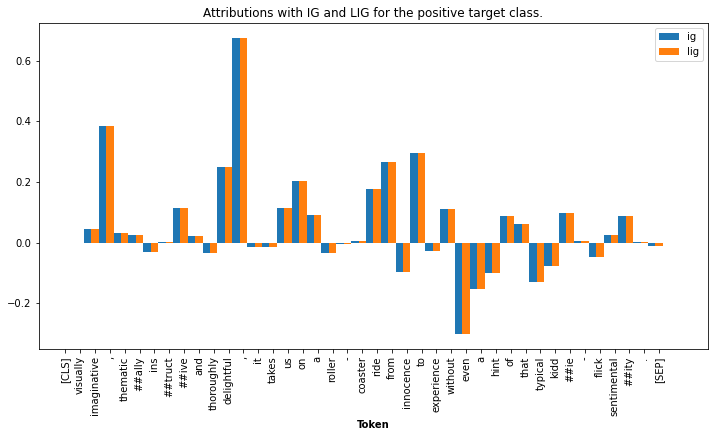

In [17]:
# Compare with IG

# Attributions for input_ids computed with IG and LIG
# word_embeddings: index 0
ig_1 = attributions_1[0].squeeze().sum(1)
lig_1 = layer_attributions_1[0].squeeze().sum(1)

tokens = tokenizer.convert_ids_to_tokens(tokenizer(text)["input_ids"])

range_ig = [x + 0.5 for x in np.arange(len(ig_1))]
range_lig = [x + 0.5 for x in range_ig]
 
plt.rcParams["figure.figsize"] = [12, 6] 
plt.bar(range_ig, ig_1, width=0.5, label='ig')
plt.bar(range_lig, lig_1, width=0.5, label='lig')
plt.xlabel('Token', fontweight='bold')
plt.xticks(list(range(len(lig_1))), tokens, rotation='vertical')
plt.legend()
plt.title("Attributions with IG and LIG for the positive target class.")
plt.show()

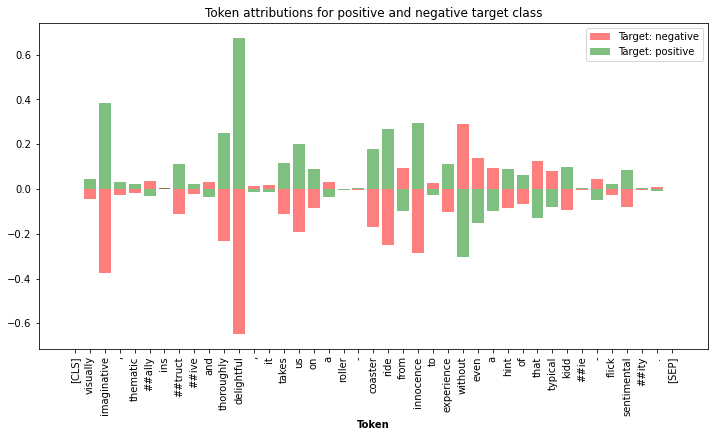

In [18]:
# Plot for both target classes
# Attributions assigned to tokens may take opposite values when computed with regard to class 0 and class 1.

# Attributions for word_embeddings: index 0
lig_0 = layer_attributions_0[0].squeeze().sum(1)
lig_1 = layer_attributions_1[0].squeeze().sum(1)

tokens = tokenizer.convert_ids_to_tokens(tokenizer(text)["input_ids"])

plt.rcParams["figure.figsize"] = [12, 6]
plt.bar(list(range(len(lig_0))), lig_0, color='r', alpha=0.5)
plt.bar(list(range(len(lig_1))), lig_1, color='g', alpha=0.5)
plt.xticks(list(range(len(lig_0))), tokens, rotation='vertical')
plt.legend(labels=["Target: negative", "Target: positive"])
plt.xlabel('Token', fontweight='bold')
plt.title("Token attributions for positive and negative target class")
plt.show()